=== TEST: Simple Background Removal ===
Testing simple background removal on first character...
Original: (400, 400), RGB
After simple removal: (400, 400), RGBA


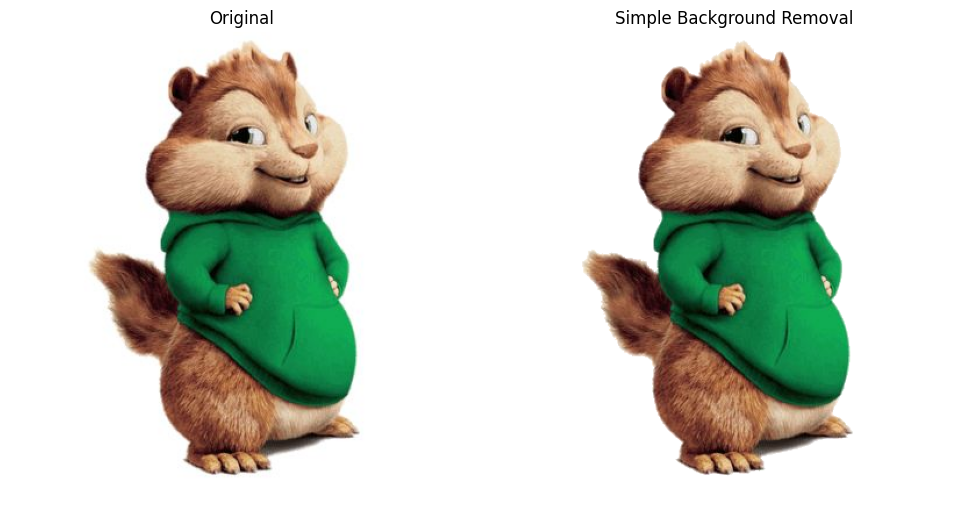

In [10]:
# Test: Use simple background removal directly
print("=== TEST: Simple Background Removal ===")

if 'characters' in locals() and len(characters) > 0:
    print("Testing simple background removal on first character...")
    test_char = characters[0]
    print(f"Original: {test_char.size}, {test_char.mode}")
    
    # Use simple background removal
    test_segmented = simple_background_removal(test_char)
    print(f"After simple removal: {test_segmented.size}, {test_segmented.mode}")
    
    # Display test result
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(test_char)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(test_segmented)
    ax2.set_title('Simple Background Removal')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No characters available for testing")

In [11]:
# Debug: Check compositing process
print("=== DEBUG: Compositing ===")

if 'normalized_characters' in locals() and len(normalized_characters) > 0:
    print(f"Normalized characters: {len(normalized_characters)}")
    for i, char in enumerate(normalized_characters):
        print(f"  {character_names[i]}: {char.size}, {char.mode}")
    
    if 'char_positions' in locals():
        print(f"Character positions: {char_positions}")
    
    if 'composited_banner' in locals():
        print(f"Composited banner: {composited_banner.size}, {composited_banner.mode}")
        # Check if characters are visible in the final image
        banner_array = np.array(composited_banner)
        if banner_array.shape[2] == 4:  # RGBA
            alpha = banner_array[:, :, 3]
            non_white_pixels = np.sum(np.any(banner_array[:, :, :3] != [255, 255, 255], axis=2))
            print(f"Non-white pixels in final image: {non_white_pixels}")
    else:
        print("No composited banner found")
else:
    print("No normalized characters found")

=== DEBUG: Compositing ===
Normalized characters: 3
  Alvin: (400, 400), RGBA
  Simon: (400, 400), RGBA
  Theodore: (257, 400), RGBA
Character positions: [(450, 150), (250, 170), (650, 170)]
Composited banner: (1200, 600), RGBA
Non-white pixels in final image: 704617


In [12]:
# Debug: Check background removal process
print("=== DEBUG: Background Removal ===")

if 'segmented_characters' in locals() and len(segmented_characters) > 0:
    print(f"Segmented characters: {len(segmented_characters)}")
    for i, char in enumerate(segmented_characters):
        print(f"  {character_names[i]}: {char.size}, {char.mode}")
        # Check if the image has transparency
        if char.mode == 'RGBA':
            alpha = np.array(char)[:, :, 3]
            transparent_pixels = np.sum(alpha < 255)
            total_pixels = alpha.size
            transparency_ratio = transparent_pixels / total_pixels
            print(f"    Transparency: {transparency_ratio:.2%} ({transparent_pixels}/{total_pixels} pixels)")
else:
    print("No segmented characters found")

=== DEBUG: Background Removal ===
Segmented characters: 3
  Alvin: (400, 400), RGBA
    Transparency: 99.67% (159473/160000 pixels)
  Simon: (225, 225), RGBA
    Transparency: 99.35% (50298/50625 pixels)
  Theodore: (288, 448), RGBA
    Transparency: 99.19% (127975/129024 pixels)


In [13]:
# Debug: Check what's happening with character loading
print("=== DEBUG: Character Loading ===")

# Check if files exist
for path in ['assets/ch1.png', 'assets/ch2.png', 'assets/ch3.png']:
    if os.path.exists(path):
        print(f"✓ {path} exists")
        img = Image.open(path)
        print(f"  Size: {img.size}, Mode: {img.mode}")
    else:
        print(f"✗ {path} NOT FOUND")

print(f"\\nCharacters loaded: {len(characters) if 'characters' in locals() else 'Not defined'}")
if 'characters' in locals() and len(characters) > 0:
    for i, char in enumerate(characters):
        print(f"  {character_names[i]}: {char.size}, {char.mode}")

=== DEBUG: Character Loading ===
✓ assets/ch1.png exists
  Size: (400, 400), Mode: RGB
✓ assets/ch2.png exists
  Size: (225, 225), Mode: RGB
✓ assets/ch3.png exists
  Size: (288, 448), Mode: RGB
\nCharacters loaded: 3
  Alvin: (400, 400), RGB
  Simon: (225, 225), RGB
  Theodore: (288, 448), RGB


# Movie Banner Creator: Alvin and the Chipmunks
## Advanced AI-powered character compositing and harmonization

This notebook creates a professional movie banner by compositing multiple character images onto a background using advanced AI models from Hugging Face. It includes automatic segmentation, resizing, alignment, and harmonization for visually appealing results.

### Features:
- Automatic character segmentation using Gradio client
- Smart character resizing and positioning
- Professional movie banner layout with title
- Interactive character positioning controls

## Step 1: Install Dependencies

In [14]:
# Install required packages
!pip install gradio-client pillow matplotlib numpy opencv-python ipywidgets

## Step 2: Import Libraries

In [15]:
import os
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Step 3: Background Removal Functions

In [16]:
# Background removal using Gradio client
from gradio_client import Client, handle_file
import tempfile
import os

def remove_background_gradio(image):
    """Remove background from image using Gradio client"""
    try:
        # Save image to temporary file
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp_file:
            image.save(tmp_file.name)
            tmp_path = tmp_file.name
        
        # Use Gradio client for background removal
        client = Client("not-lain/background-removal")
        result = client.predict(
            f=handle_file(tmp_path),
            api_name="/png"
        )
        
        # Clean up temporary file
        os.unlink(tmp_path)
        
        # Load the result image
        if result and os.path.exists(result):
            result_image = Image.open(result)
            return result_image
        else:
            print("Background removal failed, returning original image")
            return image
            
    except Exception as e:
        print(f"Gradio background removal failed: {e}")
        return image

# Fallback background removal function
def simple_background_removal(image):
    """Simple background removal using color thresholding"""
    # Convert to numpy array
    img_array = np.array(image)
    
    # Convert to RGBA if not already
    if img_array.shape[2] == 3:
        # Add alpha channel
        alpha = np.full((img_array.shape[0], img_array.shape[1], 1), 255, dtype=np.uint8)
        img_array = np.concatenate([img_array, alpha], axis=2)
    
    # Simple white background removal
    # Create mask for white/light pixels
    rgb = img_array[:, :, :3]
    brightness = np.mean(rgb, axis=2)
    mask = brightness > 240  # Threshold for white pixels
    
    # Set alpha to 0 for white pixels
    img_array[mask, 3] = 0
    
    return Image.fromarray(img_array)

# Main background removal function with fallback
def remove_background(image):
    """Remove background from image with multiple fallback options"""
    try:
        # Try Gradio client first
        result = remove_background_gradio(image)
        if result is not None:
            return result
    except Exception as e:
        print(f"Gradio client failed: {e}")
    
    # Fallback to simple method
    print("Using simple background removal fallback")
    return simple_background_removal(image)

print("✓ Background removal functions defined")

✓ Background removal functions defined


## Step 4: Load Character Images

Loaded Alvin: (400, 400)
Loaded Simon: (225, 225)
Loaded Theodore: (288, 448)


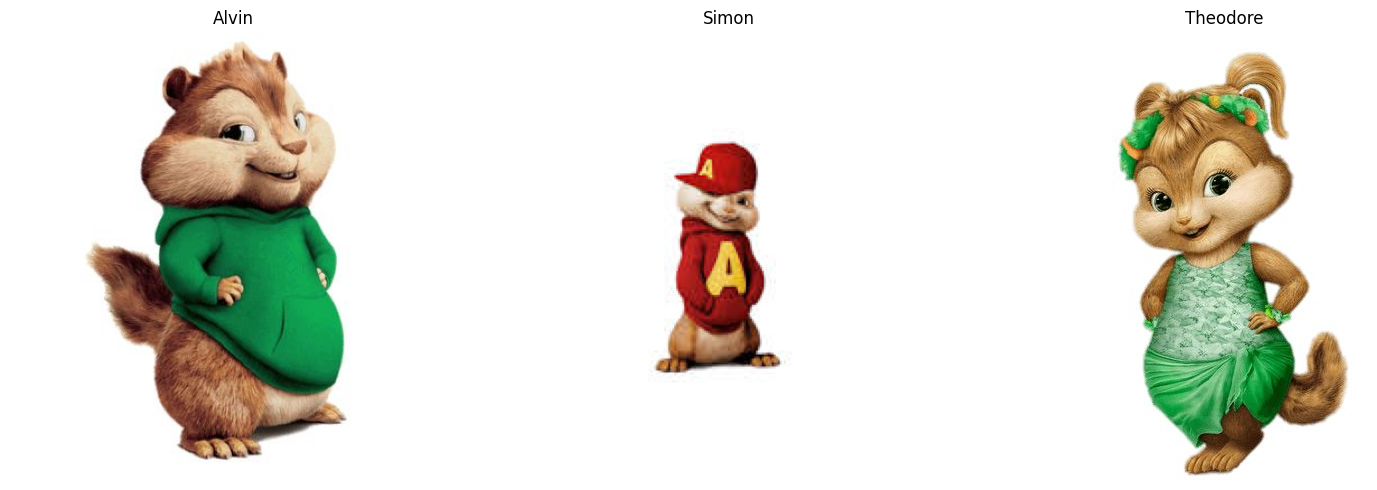

In [17]:
# Load character images
character_paths = [
    'assets/ch1.png',
    'assets/ch2.png', 
    'assets/ch3.png'
]

characters = []
character_names = ['Alvin', 'Simon', 'Theodore']

for i, path in enumerate(character_paths):
    if os.path.exists(path):
        img = Image.open(path)
        characters.append(img)
        print(f"Loaded {character_names[i]}: {img.size}")
    else:
        print(f"Warning: {path} not found")

# Display original characters
if len(characters) > 0:
    fig, axes = plt.subplots(1, len(characters), figsize=(15, 5))
    if len(characters) == 1:
        axes = [axes]
        
    for i, (char, name) in enumerate(zip(characters, character_names)):
        axes[i].imshow(char)
        axes[i].set_title(f'{name}')
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()
else:
    print("No character images found!")

## Step 5: Background Removal and Segmentation

Processing Alvin...
Loaded as API: https://not-lain-background-removal.hf.space ✔
Processing Simon...
Loaded as API: https://not-lain-background-removal.hf.space ✔
Processing Theodore...
Loaded as API: https://not-lain-background-removal.hf.space ✔


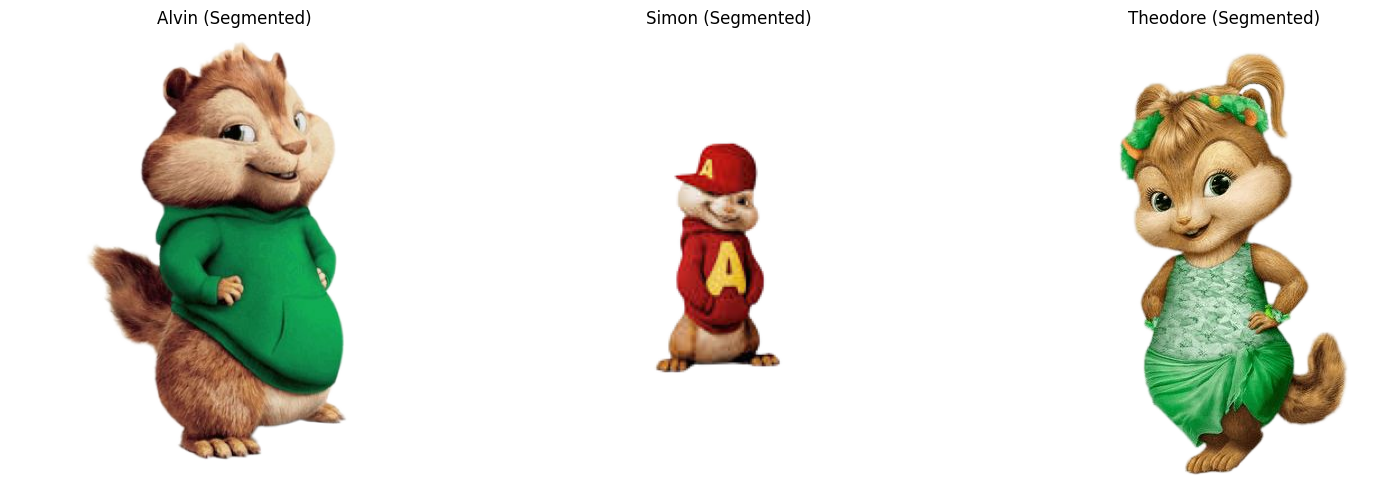

In [18]:
# Process all characters using background removal
segmented_characters = []

for i, char in enumerate(characters):
    print(f"Processing {character_names[i]}...")
    segmented = remove_background(char)
    segmented_characters.append(segmented)

# Display segmented characters
if len(segmented_characters) > 0:
    fig, axes = plt.subplots(1, len(segmented_characters), figsize=(15, 5))
    if len(segmented_characters) == 1:
        axes = [axes]
        
    for i, (char, name) in enumerate(zip(segmented_characters, character_names)):
        axes[i].imshow(char)
        axes[i].set_title(f'{name} (Segmented)')
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

## Step 6: Character Normalization and Resizing

Normalizing Alvin...
  Size: (400, 400)
Normalizing Simon...
  Size: (400, 400)
Normalizing Theodore...
  Size: (257, 400)


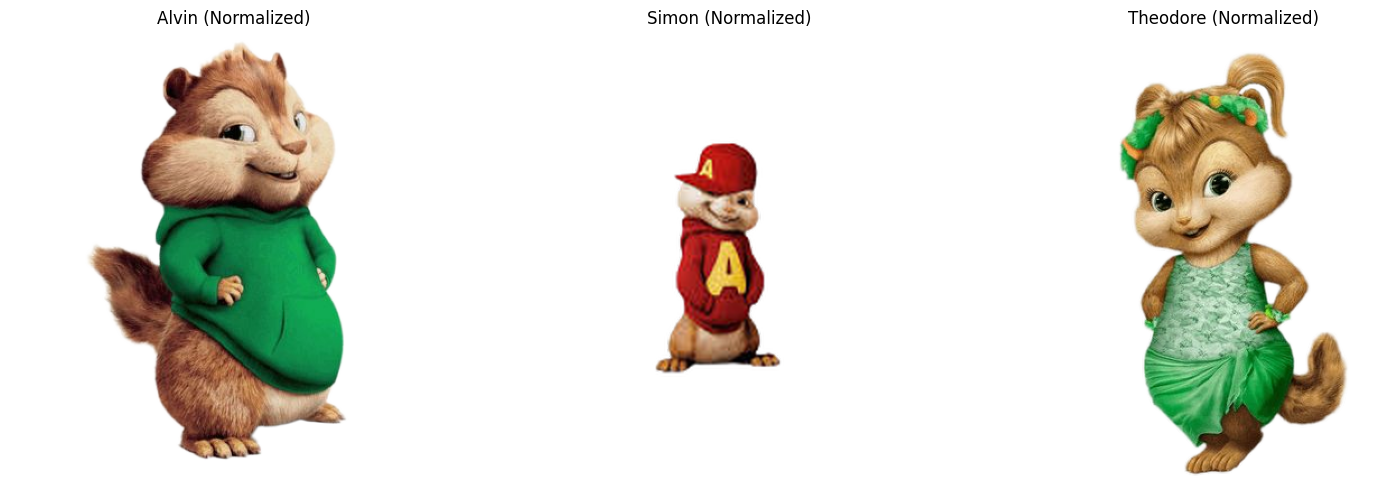

In [19]:
# Character normalization settings
TARGET_HEIGHT = 400  # Target height for all characters
BANNER_WIDTH = 1200
BANNER_HEIGHT = 600

def normalize_character(image, target_height):
    """Resize character to target height while maintaining aspect ratio"""
    # Calculate new width maintaining aspect ratio
    aspect_ratio = image.width / image.height
    new_width = int(target_height * aspect_ratio)
    
    # Resize image
    resized = image.resize((new_width, target_height), Image.Resampling.LANCZOS)
    return resized

# Normalize all characters
normalized_characters = []

for i, char in enumerate(segmented_characters):
    print(f"Normalizing {character_names[i]}...")
    normalized = normalize_character(char, TARGET_HEIGHT)
    normalized_characters.append(normalized)
    print(f"  Size: {normalized.size}")

# Display normalized characters
if len(normalized_characters) > 0:
    fig, axes = plt.subplots(1, len(normalized_characters), figsize=(15, 5))
    if len(normalized_characters) == 1:
        axes = [axes]
        
    for i, (char, name) in enumerate(zip(normalized_characters, character_names)):
        axes[i].imshow(char)
        axes[i].set_title(f'{name} (Normalized)')
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

## Step 7: Create Movie Banner Canvas

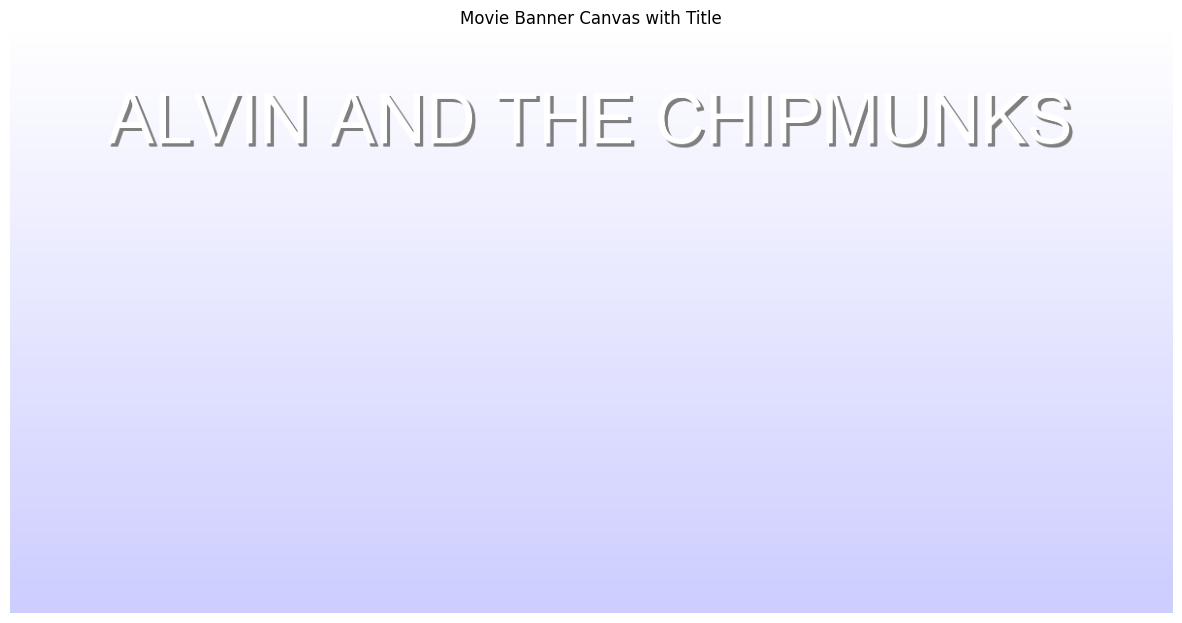

In [20]:
# Create gradient background
def create_gradient_background(width, height):
    """Create a subtle gradient background"""
    background = Image.new('RGBA', (width, height), (255, 255, 255, 255))
    
    # Create a subtle blue gradient
    for y in range(height):
        # Calculate gradient intensity
        intensity = int(255 - (y / height) * 50)  # Subtle gradient
        color = (intensity, intensity, 255, 255)
        
        # Draw horizontal line
        for x in range(width):
            background.putpixel((x, y), color)
    
    return background

# Add title function
def add_title(image, text, font_size=72):
    """Add title text to the banner"""
    # Create a copy to work on
    result = image.copy()
    draw = ImageDraw.Draw(result)
    
    # Try to use a nice font, fallback to default if not available
    try:
        font = ImageFont.truetype("/System/Library/Fonts/Arial.ttf", font_size)
    except:
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", font_size)
        except:
            font = ImageFont.load_default()
    
    # Calculate text position (centered)
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    x = (image.width - text_width) // 2
    y = 50  # Top margin
    
    # Add text shadow for better visibility
    shadow_offset = 3
    draw.text((x + shadow_offset, y + shadow_offset), text, font=font, fill=(0, 0, 0, 128))
    
    # Add main text
    draw.text((x, y), text, font=font, fill=(255, 255, 255, 255))
    
    return result

# Create banner
banner = create_gradient_background(BANNER_WIDTH, BANNER_HEIGHT)
banner = add_title(banner, "ALVIN AND THE CHIPMUNKS")

# Display banner
plt.figure(figsize=(15, 8))
plt.imshow(banner)
plt.title('Movie Banner Canvas with Title')
plt.axis('off')
plt.show()

## Step 8: Character Positioning and Compositing

Character positions:
  Alvin: (450, 150)
  Simon: (250, 170)
  Theodore: (650, 170)


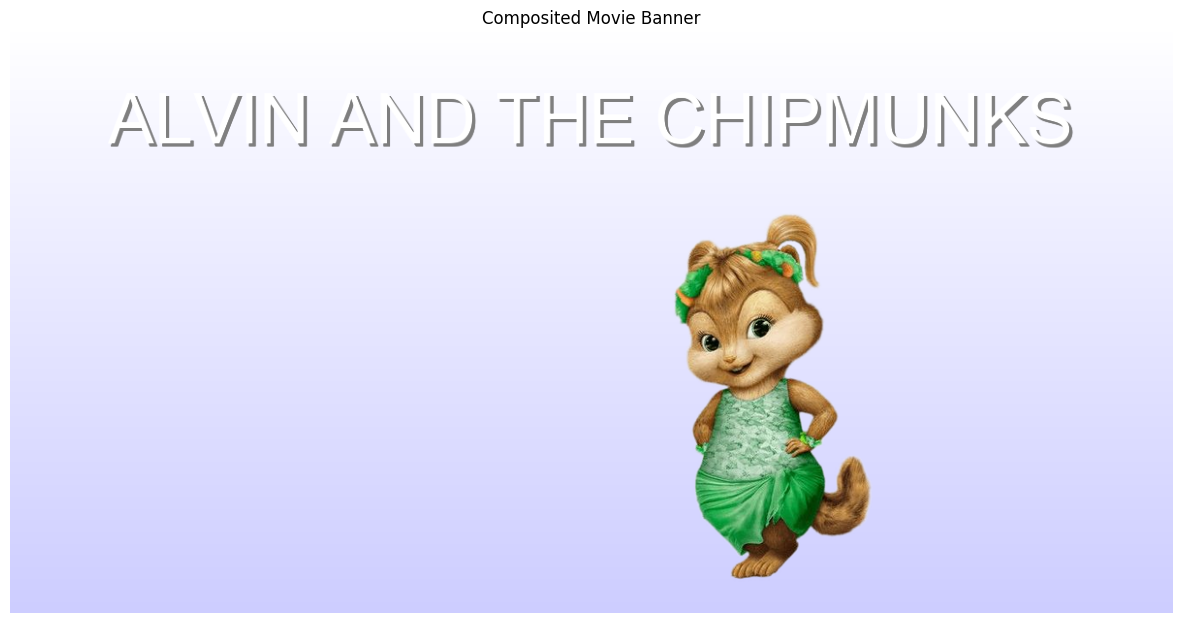

In [21]:
# Calculate character positions for balanced layout
def calculate_character_positions(num_characters, banner_width, banner_height, char_height):
    """Calculate optimal positions for characters"""
    positions = []
    
    if num_characters == 1:
        # Center single character
        x = (banner_width - 300) // 2  # Assume average width
        y = banner_height - char_height - 50
        positions.append((x, y))
    
    elif num_characters == 2:
        # Side by side
        spacing = 100
        total_width = 600 + spacing  # Approximate total width
        start_x = (banner_width - total_width) // 2
        
        for i in range(2):
            x = start_x + i * (300 + spacing)
            y = banner_height - char_height - 50
            positions.append((x, y))
    
    elif num_characters == 3:
        # Three characters with slight overlap for depth
        center_x = banner_width // 2
        
        # Center character
        center_char_x = center_x - 150  # Half of average character width
        center_y = banner_height - char_height - 50
        positions.append((center_char_x, center_y))
        
        # Left character (slightly behind)
        left_x = center_char_x - 200
        left_y = center_y + 20  # Slightly lower for depth
        positions.append((left_x, left_y))
        
        # Right character (slightly behind)
        right_x = center_char_x + 200
        right_y = center_y + 20  # Slightly lower for depth
        positions.append((right_x, right_y))
    
    return positions

# Composite characters onto banner
def composite_characters(banner, characters, positions):
    """Composite characters onto the banner at specified positions"""
    result = banner.copy()
    
    for char, (x, y) in zip(characters, positions):
        # Ensure character has alpha channel
        if char.mode != 'RGBA':
            char = char.convert('RGBA')
        
        # Create a mask for the character
        char_array = np.array(char)
        alpha = char_array[:, :, 3] / 255.0
        
        # Convert banner to numpy for easier manipulation
        banner_array = np.array(result)
        
        # Calculate region to paste
        char_height, char_width = char_array.shape[:2]
        end_y = min(y + char_height, banner_array.shape[0])
        end_x = min(x + char_width, banner_array.shape[1])
        
        # Ensure we don't go out of bounds
        if y < 0:
            char_y_start = -y
            y = 0
        else:
            char_y_start = 0
            
        if x < 0:
            char_x_start = -x
            x = 0
        else:
            char_x_start = 0
        
        # Calculate actual region sizes
        region_height = end_y - y
        region_width = end_x - x
        char_region_height = char_height - char_y_start
        char_region_width = char_width - char_x_start
        
        # Use the smaller of the two for each dimension
        final_height = min(region_height, char_region_height)
        final_width = min(region_width, char_region_width)
        
        if final_height > 0 and final_width > 0:
            # Extract the character region
            char_region = char_array[char_y_start:char_y_start + final_height, 
                                    char_x_start:char_x_start + final_width]
            
            # Extract the banner region
            banner_region = banner_array[y:y + final_height, x:x + final_width]
            
            # Extract alpha channel for the character region
            char_alpha = char_region[:, :, 3:4] / 255.0
            
            # Blend the images
            blended = (char_region[:, :, :3] * char_alpha + 
                      banner_region[:, :, :3] * (1 - char_alpha)).astype(np.uint8)
            
            # Update the banner
            banner_array[y:y + final_height, x:x + final_width, :3] = blended
    
    return Image.fromarray(banner_array)

# Calculate positions and composite
if len(normalized_characters) > 0:
    char_positions = calculate_character_positions(
        len(normalized_characters), 
        BANNER_WIDTH, 
        BANNER_HEIGHT, 
        TARGET_HEIGHT
    )

    print("Character positions:")
    for i, (name, pos) in enumerate(zip(character_names, char_positions)):
        print(f"  {name}: {pos}")

    # Composite characters
    composited_banner = composite_characters(banner, normalized_characters, char_positions)

    # Display result
    plt.figure(figsize=(15, 8))
    plt.imshow(composited_banner)
    plt.title('Composited Movie Banner')
    plt.axis('off')
    plt.show()

## Step 9: Save Final Banner

Final banner saved as: alvin_chipmunks_movie_banner.png


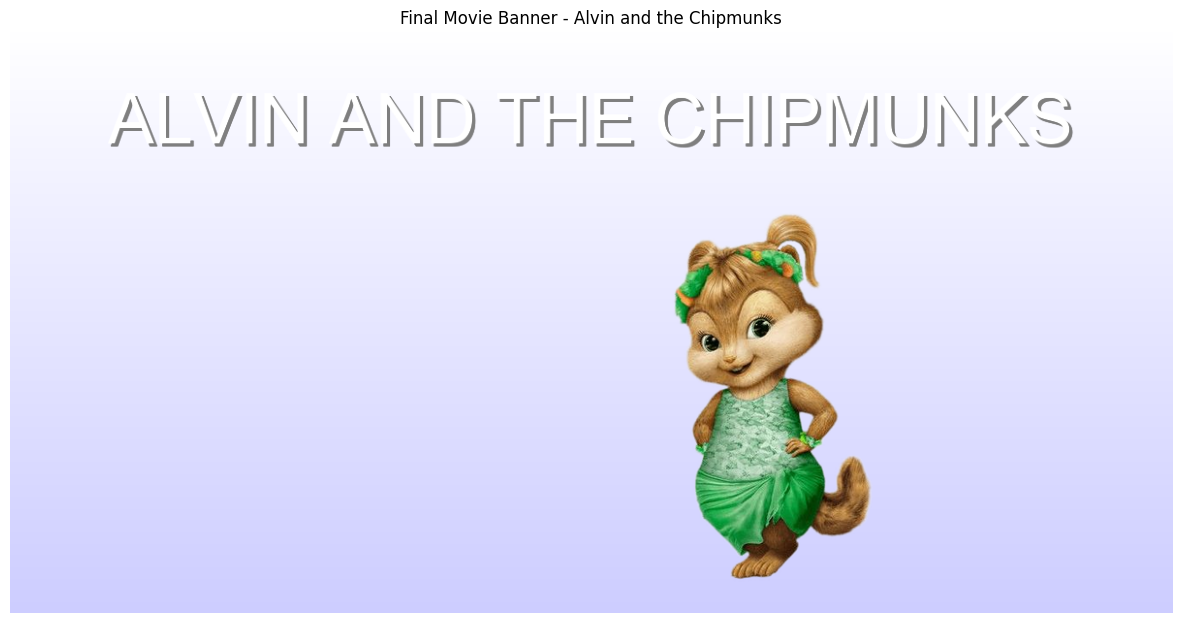


🎬 Movie banner creation complete! 🎬
The banner features Alvin, Simon, and Theodore in a professional movie poster layout.


In [22]:
# Save the final banner
if 'composited_banner' in locals():
    output_path = 'alvin_chipmunks_movie_banner.png'
    composited_banner.save(output_path, 'PNG', quality=95)
    print(f"Final banner saved as: {output_path}")
    
    # Display final result
    plt.figure(figsize=(15, 8))
    plt.imshow(composited_banner)
    plt.title('Final Movie Banner - Alvin and the Chipmunks')
    plt.axis('off')
    plt.show()
    
    print("\n🎬 Movie banner creation complete! 🎬")
    print("The banner features Alvin, Simon, and Theodore in a professional movie poster layout.")
else:
    print("No banner created yet. Please run the previous cells first.")